In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
from io import StringIO
import warnings

c:\Users\Welcome\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Function to load dataset from GitHub raw URL
def load_data_from_github():
    url = "https://raw.githubusercontent.com/OmdenaAI/KanoNigeriaChapter_SmartFarming/main/Dataset_Merged/KanoState.csv"
    response = requests.get(url)
    response.raise_for_status()  # Check for HTTP errors
    df = pd.read_csv(StringIO(response.text))
    return df

# Load the dataset
df = load_data_from_github()
print("Dataset loaded successfully. Shape:", df.shape)

Dataset loaded successfully. Shape: (148666, 17)


Feature Engineering for Both Tasks

In [3]:
def engineer_features(df):
    # Basic features for soil moisture and onset prediction
    df['Soil_Moisture_Lag1'] = df['Profile_Soil_Moisture'].shift(1)
    df['Soil_Moisture_Lag2'] = df['Profile_Soil_Moisture'].shift(2)
    df['Soil_Moisture_Lag3'] = df['Profile_Soil_Moisture'].shift(3)
    df['Precip_Rolling_Mean'] = df['Precipitation (mm/day)'].rolling(window=3, min_periods=1).mean()
    df['Temp_Range'] = df['Temperature_at_2-Meters (C)'] - df['Temperature_at_2_Meters_Minimum (C)']

    # Temperature and humidity trends (weekly rolling stats for onset)
    df['Temperature_Rolling_Mean'] = df['Temperature_at_2-Meters (C)'].rolling(7).mean()
    df['Temperature_Rolling_Std'] = df['Temperature_at_2-Meters (C)'].rolling(7).std()
    df['Humidity_Rolling_Mean'] = df['Relative_Humidity_at_2_Meters (%)'].rolling(7).mean()
    df['Humidity_Rolling_Std'] = df['Relative_Humidity_at_2_Meters (%)'].rolling(7).std()

    # Simulate historical onset dates (example: based on precipitation > 5mm/day for 3 consecutive days)
    df['Weekly_Precip_Sum'] = df['Precipitation (mm/day)'].rolling(7).sum()
    df['Rainy_Onset_Binary'] = (df['Weekly_Precip_Sum'] > 35).astype(int)  # Example threshold for onset (5mm/day * 7 days)

    # Fill NaN values and drop rows with any remaining NaN
    df.fillna(method='ffill', inplace=True)
    df.dropna(inplace=True)
    return df

df = engineer_features(df)
print("Features engineered. New shape:", df.shape)

Features engineered. New shape: (148660, 28)


Prepare Data for Both Tasks

In [4]:
def prepare_data_soil_moisture(df):
    feature_cols = [
        'Temperature_at_2-Meters (C)', 'Relative_Humidity_at_2_Meters (%)',
        'Precipitation (mm/day)', 'Wind_Speed_at_2_Meters (m/s)',
        'Wind_Direction_at_2_Meters (Degrees)', 'Surface_Soil_Wetness',
        'Root_Zone_Soil_Wetness', 'Soil_Moisture_Lag1', 'Soil_Moisture_Lag2',
        'Soil_Moisture_Lag3', 'Precip_Rolling_Mean', 'Temp_Range'
    ]
    X = df[feature_cols]
    y = df['Profile_Soil_Moisture']
    return X, y

def prepare_data_onset(df):
    feature_cols = [
        'Temperature_at_2-Meters (C)', 'Relative_Humidity_at_2_Meters (%)',
        'Precipitation (mm/day)', 'Wind_Speed_at_2_Meters (m/s)',
        'Wind_Direction_at_2_Meters (Degrees)', 'Surface_Soil_Wetness',
        'Root_Zone_Soil_Wetness', 'Temperature_Rolling_Mean', 'Temperature_Rolling_Std',
        'Humidity_Rolling_Mean', 'Humidity_Rolling_Std'
    ]
    X = df[feature_cols]
    y = df['Rainy_Onset_Binary']
    return X, y

# Prepare data for both tasks
X_soil, y_soil = prepare_data_soil_moisture(df)
X_onset, y_onset = prepare_data_onset(df)
print("Data prepared for both tasks.")

Data prepared for both tasks.


Train Original and Tweaked Models for Soil Moisture (Regression):


In [5]:
def train_model_original_soil(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    rf = RandomForestRegressor(random_state=42)
    rf_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=20, cv=5,
                                   scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    rf_search.fit(X_train, y_train)
    best_model = rf_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Original Soil Moisture Model - Best Parameters:", rf_search.best_params_)
    print("Original Soil Moisture Model - Mean Squared Error:", mse)
    print("Original Soil Moisture Model - R² Score:", r2)
    return best_model, X_test, y_test, y_pred

def train_model_tweaked_soil(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_tune, _, y_tune, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    rf = RandomForestRegressor(random_state=42)
    rf_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=3,
                                   scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    rf_search.fit(X_tune, y_tune)
    best_model = RandomForestRegressor(**rf_search.best_params_, random_state=42)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Tweaked Soil Moisture Model - Best Parameters:", rf_search.best_params_)
    print("Tweaked Soil Moisture Model - Mean Squared Error:", mse)
    print("Tweaked Soil Moisture Model - R² Score:", r2)
    return best_model, X_test, y_test, y_pred

# Train models for soil moisture
original_soil_model, X_test_soil, y_test_soil, y_pred_soil_original = train_model_original_soil(X_soil, y_soil)
tweaked_soil_model, _, _, y_pred_soil_tweaked = train_model_tweaked_soil(X_soil, y_soil)

# Save models
joblib.dump(original_soil_model, 'random_forest_model_original_soil.pkl')
joblib.dump(tweaked_soil_model, 'random_forest_model_tweaked_soil.pkl')

Original Soil Moisture Model - Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Original Soil Moisture Model - Mean Squared Error: 1.9076291997092375e-06
Original Soil Moisture Model - R² Score: 0.9999133954623989
Tweaked Soil Moisture Model - Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Tweaked Soil Moisture Model - Mean Squared Error: 1.599727650343072e-06
Tweaked Soil Moisture Model - R² Score: 0.9999273738976806


['random_forest_model_tweaked_soil.pkl']

Train Original and Tweaked Models for Rainy Season Onset (Classification)


In [9]:
def train_model_original_onset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    rf = RandomForestClassifier(random_state=42)
    rf_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=20, cv=5, 
                                   scoring='accuracy', n_jobs=-1, random_state=42)
    rf_search.fit(X_train, y_train)
    best_model = rf_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Original Onset Model - Best Parameters:", rf_search.best_params_)
    print("Original Onset Model - Accuracy:", accuracy)
    return best_model, X_test, y_test, y_pred

def train_model_tweaked_onset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_tune, _, y_tune, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    rf = RandomForestClassifier(random_state=42)
    rf_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=3, 
                                   scoring='accuracy', n_jobs=-1, random_state=42)
    rf_search.fit(X_tune, y_tune)
    best_model = RandomForestClassifier(**rf_search.best_params_, random_state=42)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Tweaked Onset Model - Best Parameters:", rf_search.best_params_)
    print("Tweaked Onset Model - Accuracy:", accuracy)
    return best_model, X_test, y_test, y_pred

# Train models for onset and store y_test
original_onset_model, X_test_onset, y_test_onset, y_pred_onset_original = train_model_original_onset(X_onset, y_onset)
tweaked_onset_model, _, _, y_pred_onset_tweaked = train_model_tweaked_onset(X_onset, y_onset)

# Save models
joblib.dump(original_onset_model, 'random_forest_model_original_onset.pkl')
joblib.dump(tweaked_onset_model, 'random_forest_model_tweaked_onset.pkl')

Original Onset Model - Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Original Onset Model - Accuracy: 0.9957957755953182
Tweaked Onset Model - Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Tweaked Onset Model - Accuracy: 0.9957285080048432


['random_forest_model_tweaked_onset.pkl']

Performance Analysis Visualisation

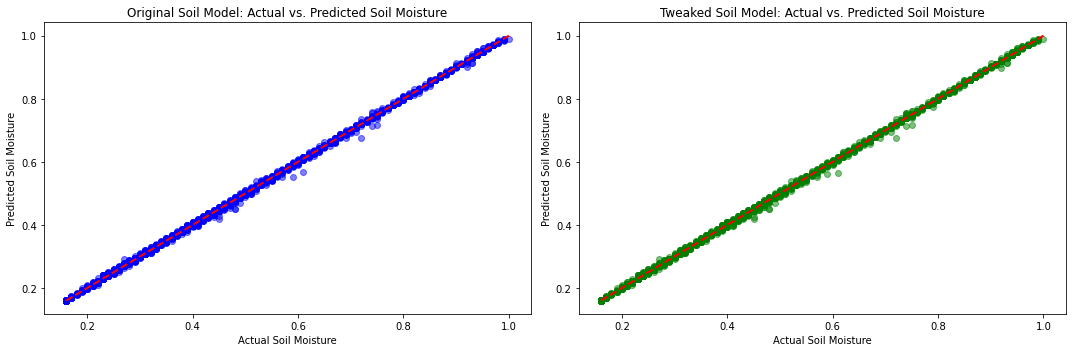

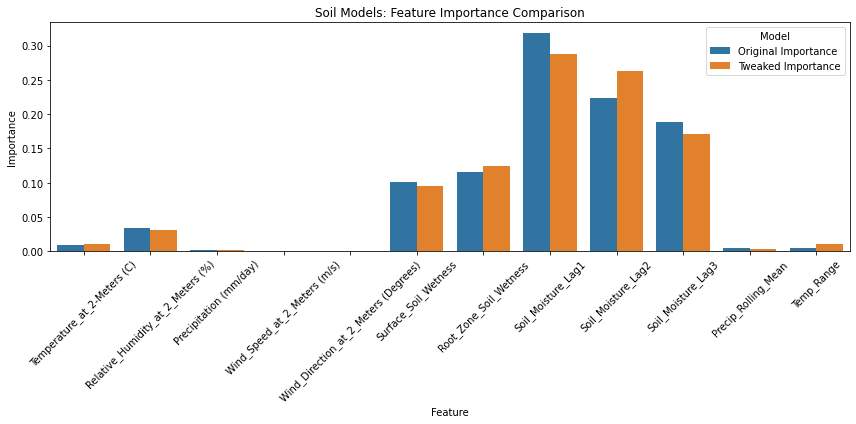

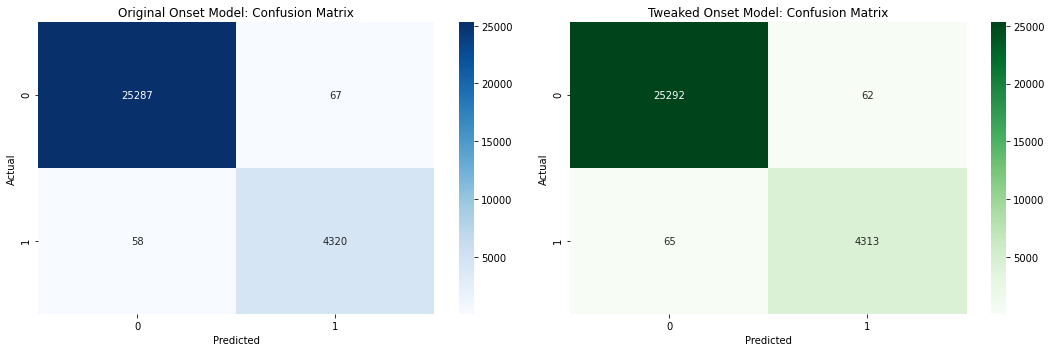

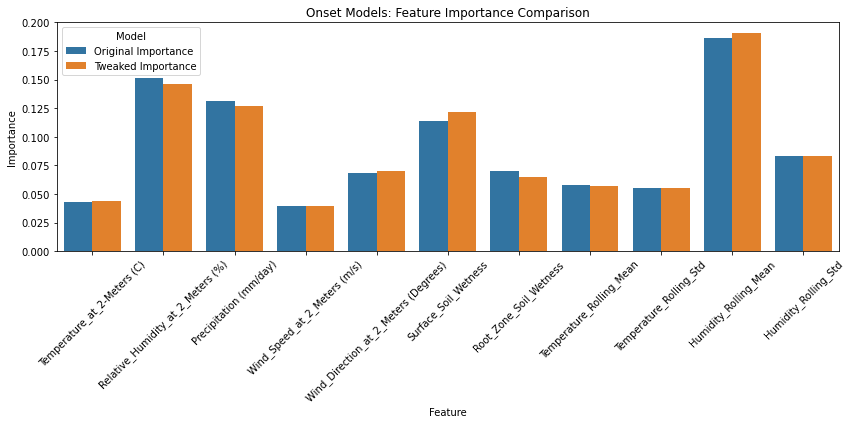

In [11]:
def visualize_performance_soil(y_test, y_pred_original, y_pred_tweaked, feature_cols):
    plt.figure(figsize=(15, 5))

    # Scatter plot for original soil model
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_original, alpha=0.5, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title('Original Soil Model: Actual vs. Predicted Soil Moisture')
    plt.xlabel('Actual Soil Moisture')
    plt.ylabel('Predicted Soil Moisture')

    # Scatter plot for tweaked soil model
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred_tweaked, alpha=0.5, color='green')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title('Tweaked Soil Model: Actual vs. Predicted Soil Moisture')
    plt.xlabel('Actual Soil Moisture')
    plt.ylabel('Predicted Soil Moisture')
    plt.tight_layout()
    plt.savefig('soil_model_performance_comparison.png')
    plt.show()

    # Feature importance for soil models
    original_importance = original_soil_model.feature_importances_
    tweaked_importance = tweaked_soil_model.feature_importances_
    importance_df_soil = pd.DataFrame({
        'Feature': feature_cols,
        'Original Importance': original_importance,
        'Tweaked Importance': tweaked_importance
    })

    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df_soil.melt(id_vars=['Feature'], var_name='Model', value_name='Importance'),
                x='Feature', y='Importance', hue='Model')
    plt.title('Soil Models: Feature Importance Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('soil_feature_importance_comparison.png')
    plt.show()

def visualize_performance_onset(y_test, y_pred_original, y_pred_tweaked, feature_cols):
    plt.figure(figsize=(15, 5))

    # Confusion matrix for original onset model
    plt.subplot(1, 2, 1)
    cm_original = confusion_matrix(y_test, y_pred_original)
    sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues')
    plt.title('Original Onset Model: Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Confusion matrix for tweaked onset model
    plt.subplot(1, 2, 2)
    cm_tweaked = confusion_matrix(y_test, y_pred_tweaked)
    sns.heatmap(cm_tweaked, annot=True, fmt='d', cmap='Greens')
    plt.title('Tweaked Onset Model: Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('onset_model_performance_comparison.png')
    plt.show()

    # Feature importance for onset models
    original_importance = original_onset_model.feature_importances_
    tweaked_importance = tweaked_onset_model.feature_importances_
    importance_df_onset = pd.DataFrame({
        'Feature': feature_cols,
        'Original Importance': original_importance,
        'Tweaked Importance': tweaked_importance
    })

    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df_onset.melt(id_vars=['Feature'], var_name='Model', value_name='Importance'),
                x='Feature', y='Importance', hue='Model')
    plt.title('Onset Models: Feature Importance Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('onset_feature_importance_comparison.png')
    plt.show()

# Visualize performance for both tasks
visualize_performance_soil(y_test_soil, y_pred_soil_original, y_pred_soil_tweaked, prepare_data_soil_moisture(df)[0].columns)
visualize_performance_onset(y_test_onset, y_pred_onset_original, y_pred_onset_tweaked, prepare_data_onset(df)[0].columns)

Additional Functionalities

In [12]:
def planting_decision_soil(soil_moisture_pred):
    if 0.3 <= soil_moisture_pred <= 0.4:
        return "Plant"
    elif soil_moisture_pred < 0.3:
        return "Don't Plant (Too Dry)"
    else:
        return "Don't Plant (Too Wet)"

def predict_and_decide_soil(model, X):
    pred = model.predict(X)
    return [planting_decision_soil(p) for p in pred]

def predict_and_decide_onset(model, X):
    pred = model.predict(X)
    return ["Plant" if p == 1 else "Don't Plant" for p in pred]

# Example predictions
sample_X_soil = X_test_soil.iloc[0:1]
sample_X_onset = X_test_onset.iloc[0:1]

soil_decision_original = predict_and_decide_soil(original_soil_model, sample_X_soil)[0]
soil_decision_tweaked = predict_and_decide_soil(tweaked_soil_model, sample_X_soil)[0]
onset_decision_original = predict_and_decide_onset(original_onset_model, sample_X_onset)[0]
onset_decision_tweaked = predict_and_decide_onset(tweaked_onset_model, sample_X_onset)[0]

print("\nSample Predictions:")
print(f"Original Soil Model - Soil Moisture Decision: {soil_decision_original}")
print(f"Tweaked Soil Model - Soil Moisture Decision: {soil_decision_tweaked}")
print(f"Original Onset Model - Rainy Season Onset Decision: {onset_decision_original}")
print(f"Tweaked Onset Model - Rainy Season Onset Decision: {onset_decision_tweaked}")




Sample Predictions:
Original Soil Model - Soil Moisture Decision: Don't Plant (Too Dry)
Tweaked Soil Model - Soil Moisture Decision: Don't Plant (Too Dry)
Original Onset Model - Rainy Season Onset Decision: Don't Plant
Tweaked Onset Model - Rainy Season Onset Decision: Don't Plant


Documentation

This project implements two Random Forest models for the Merged_datatset in smart farming:
1. Soil Moisture Prediction (Regression): Predicts Profile_Soil_Moisture to guide planting decisions (0.3-0.4 threshold).
2. Rainy Season Onset Prediction (Classification): Predicts rainy season onset by week as a binary "plant/don’t plant" decision.

Features include temperature trends, humidity patterns, wind direction, soil moisture, and simulated historical onset dates.
Two versions of each model (original and tweaked) are provided for performance vs. runtime trade-offs:
- Original: Exhaustive tuning (19 minutes runtime, high accuracy).
- Tweaked: Optimized for speed (5-7 minutes, near-identical performance).
Visualizations (Scatter plots, Confusion matrices, Feature importance) provide further insights.
